In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
np.random.seed(7)

Using TensorFlow backend.


In [2]:
# First we read in the airline passenger
#fileName = "data/international-airline-passengers.csv"
#fileName = "data/wolfer-sunspot-numbers-1770-to-1.csv"
#fileName ='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'
fileName ='data/total-annual-rainfall-in-inches-.csv'

# Load the data
df = pd.read_csv(fileName, engine='python', skipfooter=3)


if(fileName=='data/international-airline-passengers.csv'):
    time_column_name = 'Month'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    time_column_name='Year'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    time_column_name='Time'
    df = df[['Time', 'Close']].copy()
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    time_column_name='Year'

df[time_column_name]=pd.to_datetime(df[time_column_name], format='%Y-%m-%d')
df.set_index([time_column_name], inplace=True)


if(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    train_data = df['2016-01-01 00:00':'2016-05-01 00:00']
    #train_data = df['2016-04-01 00:00':'2016-05-01 00:00']
    #train_data = df['2016-04-27 00:00':'2016-05-01 00:00']
    test_data = df['2016-05-01 00:15':'2016-06-30 23:45']
    
    time_vals = df[train_data.index[0]:test_data.index[len(test_data)-1]]
    train_data = train_data.values.astype('float32')
    test_data = test_data.values.astype('float32')
    number_of_epochs=10
    
    # Extract the raw data, without the dates
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data and apply the data scalar
    split = 71
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=300
    
    
elif(fileName=='data/international-airline-passengers.csv'):
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data and apply the data scalar
    split = 73
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=300

elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    time_vals = df[df.index[0]:df.index[len(df)-1]]
    data = df.values
    data = data.astype('float32')
    
    # Now we split the data and apply the data scalar
    split = 60
    train_data =  data[0:split,:]
    test_data = data[split:,:]
    number_of_epochs=100


print("train data", train_data.shape)

def future_data(data,lags=1,future=1):
    X, y = [], []
    for row in range(len(data) - lags - future):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags+future-1, 0])
    return np.array(X), np.array(y)

def scale_array(y_vec):
    
    ymax = np.max(y_vec)
    ymin = np.min(y_vec)
    
    print("ymax",ymax)
    print("ymin",ymin)
    
    y_vec_scaled = np.zeros((len(y_vec),1))
    
    for k in range(0,len(y_vec)):
        y_vec_scaled[k][0] = (y_vec[k][0]-ymin)/(ymax-ymin)
    
    return y_vec_scaled,ymin,ymax

def invert_scaling(y_vec_scaled,ymin,ymax):
    
    y_vec = np.zeros(y_vec_scaled.shape)
        
        
    for k in range(0,len(y_vec_scaled)):
        y_vec[k] = ymin+(ymax-ymin)*y_vec_scaled[k]
    
    return y_vec

# Process the train and test data
train_data,train_min,train_max = scale_array(train_data)
test_data,test_min,test_max = scale_array(test_data)

lags=1
future=1

# Process the training data
X_train, y_train = future_data(train_data, lags,future)
X_test, y_test = future_data(test_data, lags,future)

train data (60, 1)
ymax 35.34
ymin 16.93
ymax 38.1
ymin 17.69


In [3]:
# create and fit Feed forward neural network model
model = Sequential()
model.add(Dense(4, input_dim=lags, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=2, verbose=1)

Epoch 1/100
58/58 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 2/100
58/58 [==============================] - 0s 505us/step - loss: 0.0556
Epoch 3/100
58/58 [==============================] - 0s 596us/step - loss: 0.0497
Epoch 4/100
58/58 [==============================] - 0s 474us/step - loss: 0.0487
Epoch 5/100
58/58 [==============================] - 0s 457us/step - loss: 0.0481
Epoch 6/100
58/58 [==============================] - 0s 537us/step - loss: 0.0483
Epoch 7/100
58/58 [==============================] - 0s 464us/step - loss: 0.0481
Epoch 8/100
58/58 [==============================] - 0s 429us/step - loss: 0.0482
Epoch 9/100
58/58 [==============================] - 0s 420us/step - loss: 0.0482
Epoch 10/100
58/58 [==============================] - 0s 438us/step - loss: 0.0484
Epoch 11/100
58/58 [==============================] - 0s 554us/step - loss: 0.0483
Epoch 12/100
58/58 [==============================] - 0s 452us/step - loss: 0.0485
Epoch 13/100
58

58/58 [==============================] - 0s 370us/step - loss: 0.0476
Epoch 100/100
58/58 [==============================] - 0s 435us/step - loss: 0.0465


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss'])


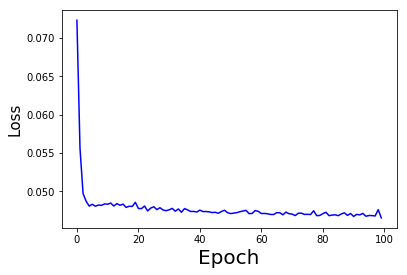

In [5]:
print(history.history.keys())


if(fileName=='data/international-airline-passengers.csv'):
    loss_label = 'Loss_airline.pdf'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    loss_label = 'Loss_sunspot.pdf'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    loss_label = 'Loss_EURUSD.pdf'
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    loss_label = 'Loss_rainfall.pdf'

plt.plot()
plt.plot(history.history['loss'],color='b')
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epoch',fontsize=20)
plt.savefig(loss_label,bboxes='tight')
plt.show()

(38, 1)
Estimated Sigma:  0.0921568426451 0.135655135524
(100, 38, 1)
-------------------------------------
MSE:  35.9929298904
RMSE:  5.99941079527
-------------------------------------


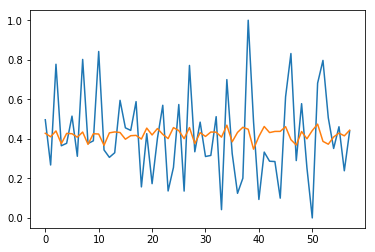

In [6]:
# generate predictions for training
uncertainty_samples = 100

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(test_predict.shape)

residuals = np.abs(y_test.reshape(-1, 1) - test_predict.reshape(-1, 1))

# Here we estimate the average residual 
sigma = 0.5*np.mean(residuals)
std_sigma =  0.5*np.std(residuals)
print("Estimated Sigma: ", sigma, np.std(residuals))

plt.plot(y_train)
plt.plot(train_predict)


test_predictions = []
for k in range(0,uncertainty_samples):
    test_predict = model.predict(X_test)+np.random.normal(sigma, std_sigma, test_predict.shape)
    test_predictions.append(test_predict)

test_predictions = np.asarray(test_predictions)



y = test_predict.flatten()[future:]

def return_min_max_prediction(test_predictions,i):
    
    y_vec = [ test_predictions[k][i][0] for k in range(0,test_predictions.shape[0])]
    
    ymin = np.min(y_vec)
    ymax = np.max(y_vec)
    
    return ymin,ymax

print(test_predictions.shape)
y_min = np.asarray([return_min_max_prediction(test_predictions,i)[0] for i in range(0,len(y))])
y_max = np.asarray([return_min_max_prediction(test_predictions,i)[1] for i in range(0,len(y))])
x = np.arange(-future,len(y_min)-future)


# Unscale all of the data
#print(y_test.shape)
y_test = invert_scaling(y_test,test_min,test_max)
y_min = invert_scaling(y_min,test_min,test_max)
y_max = invert_scaling(y_max,test_min,test_max)
y = invert_scaling(y,test_min,test_max)


# Compute the root mean squared error
mse = ((y_test[:-1].reshape(-1, 1) - y.reshape(-1, 1)) ** 2).mean()


print('-------------------------------------')
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print('-------------------------------------')


#============================================================================================
# Unscale data
#test_predictions = scaler.inverse_transform(test_predictions)
y_train = invert_scaling(y_train,train_min,train_max)
train_predict = invert_scaling(train_predict,train_min,train_max)


x_test = range(len(y_train),len(y_train)+len(y_test))
x = range(len(y_train),len(y_train)+len(y))



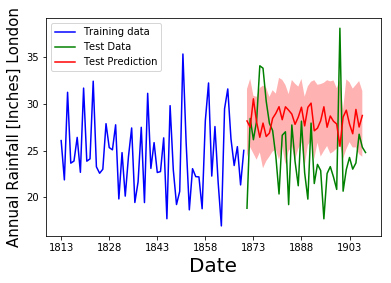

In [7]:

if(fileName=='data/international-airline-passengers.csv'):
    time_steps = 15
    time_format= "%Y"
    y_label = 'Number of Airline Passengers'
    output_name = 'Airline_Passengers_NN.pdf'
elif(fileName=='data/wolfer-sunspot-numbers-1770-to-1.csv'):
    time_steps = 10
    time_format= "%Y"
    y_label = 'Number of Sunspots'
    output_name = 'Sunspot_Forecast_NN.pdf'
elif(fileName=='data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv'):
    time_format= "%m-%H:%M"
    time_steps = 2800
    y_label = 'Exchange Rate EUR/USD'
    output_name = 'EURO_USD_exchange_rate_NN.pdf'
elif(fileName=='data/total-annual-rainfall-in-inches-.csv'):
    time_format= "%Y"
    time_steps = 15
    y_label = 'Annual Rainfall [Inches] London'
    output_name = 'Annual_Rainfall_NN.pdf'

vals= range(0,len(y_train)+len(y_test),time_steps)
labels = [time_vals.index[k].strftime(time_format) for k in vals]


plt.xticks(vals, labels)
plt.ylabel(y_label,fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.plot(y_train, label='Training data',color='b');
plt.plot(x_test,y_test.reshape(-1, 1), label='Test Data', color='g')
plt.plot(x,y, label='Test Prediction', color='red')
plt.fill_between(x, y_min, y_max, facecolor='red', interpolate=True,alpha=0.3)
plt.legend(loc=2)
plt.savefig(output_name,bboxes='tight')
plt.show()